## Información no Estructurada
# Práctica 2 &ndash; Evaluación de buscadores
### Autores:

* Bayron Portuguez
* Alvaro Alvarez

# 1.  Evaluación con juicios de relevancia

### Conexión a Google Drive

Para acceder directamente a la hoja de cálculo con los datos introducidos por los estudiantes.

In [1]:
import numpy as np
from google.colab import auth
import pandas as pd
import time

auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

### Lectura de datos de la hoja de cálculo

In [2]:
# Función de comodidad para leer datos de pestañas de una hoja de cálculo
def read_sheet(wb, name, cols=False, colnames=False, coltypes=False):
  df = pd.DataFrame(wb.worksheet(name).get_all_values())[1:]
  if cols: df = df[df.columns[cols]]
  if colnames: df.columns = colnames
  if coltypes: df = df.astype(coltypes)
  return df

# Nos conectamos a la hoja de cálculo
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1c6I2FafjKS1HlGXhYaOM2w1oqsgI7eqDOELQ3Nv7y-M')
print('Reading data...')

# Leemos los rankings
print('  Reading tab', 'Rankings', end='')
rankings = read_sheet(wb, 'Rankings', [0,1,2,3,4], ['qid', 'docid', 'pos', 'score', 'system'], {'qid':'int', 'pos':'int', 'score':'int'})
rankings = rankings[rankings.docid != '']
print('..... ok')

# Leemos los juicios de relevancia
print('  Reading relevance judgment tabs', end='')
qrels = pd.concat([read_sheet(wb, ws.title, [0, 1, 2], ['qid', 'docid', 'rel'], {'qid':'int'})
                   for ws in wb.worksheets() if ws.title.startswith('Acierto q')]).reset_index(drop=True)
print('..... ok')

# Comprobamos duplicados
pd.set_option('display.max_colwidth', 50)
duplicates = qrels[qrels.duplicated(['qid', 'docid'])]
if duplicates.size: print('\nDuplicate relevance judgments\n-----------------------------\n',
                          duplicates.to_string(index=False, max_colwidth=70))

# Comprobamos que coincidan las URLs en los rankings y juicios de relevancia
# (y de paso hacemos un join en ranking_rels para facilitar la implementación de métricas)
qm = qrels.merge(rankings, how='left')
ranking_rels = rankings.merge(qrels, how='left')
missing = ranking_rels[pd.isna(ranking_rels.rel)]
if missing.size: print('\nMissing relevance judgments\n---------------------------\n',
                       missing[['qid', 'docid']].to_string(index=False, max_colwidth=100))
missing = qm[pd.isna(qm.pos)]
if missing.size: print('\nMissing results\n---------------\n',
                       missing[['qid', 'docid']].to_string(index=False, max_colwidth=100))

Reading data...
  Reading tab Rankings..... ok
  Reading relevance judgment tabs..... ok


In [3]:
rankings.head()

,qid,docid,pos,score,system
1,0,http://en.wikipedia.org/wiki/Information_retri...,1,10,bing
2,0,http://en.wikipedia.org/wiki/Information_theory,2,9,bing
3,0,http://nlp.stanford.edu/IR-book/pdf/irbookonli...,3,8,bing
4,0,http://www.britannica.com/topic/retrieval,4,7,bing
5,0,http://nlp.stanford.edu/IR-book/information-re...,5,6,bing


In [4]:
ranking_rels.head()

,qid,docid,pos,score,system,rel
0,0,http://en.wikipedia.org/wiki/Information_retri...,1,10,bing,0
1,0,http://en.wikipedia.org/wiki/Information_theory,2,9,bing,1
2,0,http://nlp.stanford.edu/IR-book/pdf/irbookonli...,3,8,bing,1
3,0,http://www.britannica.com/topic/retrieval,4,7,bing,0
4,0,http://nlp.stanford.edu/IR-book/information-re...,5,6,bing,0


In [5]:
qrels.head()

,qid,docid,rel
0,0,http://ciir-publications.cs.umass.edu/getpdf.p...,0
1,0,http://citeseerx.ist.psu.edu/viewdoc/summary?d...,2
2,0,http://dictionary.reference.com/browse/informa...,0
3,0,http://dspace.library.uu.nl/bitstream/handle/1...,0
4,0,http://dspace.library.uu.nl/bitstream/handle/1...,1


### Implementación de las métricas

In [6]:
# Código aquí (utilizando ranking_rels, o rankings y qrels, a preferencia del estudiante)

In [7]:
#Librerias a importar
#!pip install tabulate
from tabulate import tabulate as t
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [8]:
#Convertir la columna rel en tipo int
ranking_rels['rel']= ranking_rels['rel'].astype('int')

#### Métricas clásicas
$Precision = P = \cfrac{|Relevant \cap Returned|}{|Returned|}$

$Recall = R = \cfrac{|Relevant \cap Returned|}{|Returned|}$

$Harmonic\ Average = F = \cfrac{1}{\cfrac{α}{P} +\cfrac{1-α}{R}}\       \    α\in [0,1]$



##### Precision

In [9]:
def calcular_precision(ranking, qid=None, system=None, top_k=None):
    """
    Calcula la precisión según la métrica definida.

    Parameters:
    - ranking: DataFrame con las columnas 'qid', 'system', 'rel'.
    - qid: Valor opcional para filtrar por qid específico.
    - system: Valor opcional para filtrar por sistema específico.
    - top_k: Valor opcional para especificar el límite superior del rango top k.

    Returns:
    - Precisión calculada según la métrica definida.
    """
    # Filtrar el DataFrame según los parámetros proporcionados
    df = ranking.copy()
    if qid is not None:
        df = df[df['qid'] == qid]
    if system is not None:
        df = df[df['system'] == system]
    if top_k is not None:
        df = df.head(top_k)

    # Calcular la métrica de precisión
    relevantes = df[df['rel'] != 0].shape[0]
    retornados = df.shape[0]

    # Evitar la división por cero
    if retornados == 0:
        return 0.0

    precision = relevantes / retornados
    return precision

##### Recall

In [10]:
def calcular_recall(ranking, qid=None, system=None, top_k=None):
    """
    Calcula el recall según la métrica definida.

    Parameters:
    - ranking: DataFrame con las columnas 'qid', 'system', 'rel'.
    - qid: Valor opcional para filtrar por qid específico.
    - system: Valor opcional para filtrar por sistema específico.
    - top_k: Valor opcional para especificar el límite superior del rango top k.

    Returns:
    - Recall calculado según la métrica definida.
    """
    # Filtrar el DataFrame según los parámetros proporcionados
    df = ranking.copy()
    if qid is not None:
        df = df[df['qid'] == qid]
    if system is not None:
        df = df[df['system'] == system]
    if top_k is not None:
        df = df.head(top_k)

    # Calcular la métrica de recall
    relevantes_totales = df[df['rel'] != 0].shape[0]
    relevantes_retornados = df[df['rel'] != 0].shape[0]

    # Evitar la división por cero
    if relevantes_totales == 0:
        return 0.0

    recall = relevantes_retornados / relevantes_totales
    return recall

##### Media Armónica / F Score

In [11]:
def calcular_f_score(ranking, alpha=0.5, qid=None, system=None, top_k=None):
    """
    Calcula la media armónica (F-score) según la métrica definida.

    Parameters:
    - ranking: DataFrame con las columnas 'qid', 'system', 'rel'
    - alpha: Parámetro de ponderación entre precision y recall (alpha = [0,1])
    - qid: Valor opcional para filtrar por qid específico.
    - system: Valor opcional para filtrar por sistema específico.
    - top_k: Valor opcional para especificar el límite superior del rango top k.

    Returns:
    - F-score = media armónica.
    """
    precision = calcular_precision(ranking, qid=qid, system=system, top_k=top_k)
    recall = calcular_recall(ranking, qid=qid, system=system, top_k=top_k)

    # Evitar la división por cero
    if precision == 0.0 and recall == 0.0:
        return 0.0

    f_score = 1 / ((alpha / precision) + ((1 - alpha) / recall))
    return f_score

##### Precision Recall Curve

In [12]:
def calcular_precision_recall_interpolada(ranking, num_puntos=11):
    recalls = np.linspace(0.0, 1.0, num=num_puntos)
    print(recalls)
    precision_interp = []

    for recall_target in recalls:
        # Encontrar el valor mínimo de k para el cual R@k >= recall_target
        df_recall_target = ranking#[ranking['rel'] != '']
        df_recall_target = df_recall_target.sort_values(by='pos', ascending=False)
        df_recall_target['cumulative_recall'] = df_recall_target['rel'].cumsum() / df_recall_target['rel'].sum()
        k_r = df_recall_target[df_recall_target['cumulative_recall'] >= recall_target]['cumulative_recall'].idxmin()

        # Calcular la precisión en ese punto
        print(k_r)
        precision_k_r = calcular_precision(ranking, top_k=k_r)

        precision_interp.append(precision_k_r)
    print(precision_k_r)
    print()
    return recalls, precision_interp

def graficar_precision_recall_curve(ranking, num_puntos=11):
    systems = ranking['system'].unique()

    plt.figure(figsize=(10, 6))

    for system in systems:
        ranking_system = ranking[ranking['system'] == system]
        recalls, precision_interp = calcular_precision_recall_interpolada(ranking_system, num_puntos=num_puntos)
        plt.plot(recalls, precision_interp, marker='o', linestyle='-', label=system)

    plt.title('Curva Precision/Recall por Sistema')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def calcular_precision_recall_interpolada(ranking, num_puntos=11):
    recalls = np.linspace(0.0, 1.0, num=num_puntos)
    precision_interp = []

    for recall_target in recalls:
        # Encontrar el valor mínimo de k para el cual R@k >= recall_target
        df_recall_target = ranking[ranking['rel'] != 0]
        df_recall_target = df_recall_target.sort_values(by='pos', ascending=False)

        # Manejar caso especial cuando todos los valores en 'rel' son cero
        if df_recall_target.empty:
            k_r = 0
        else:
            df_recall_target['cumulative_recall'] = df_recall_target['rel'].cumsum() / df_recall_target['rel'].sum()
            k_r = df_recall_target[df_recall_target['cumulative_recall'] >= recall_target]['cumulative_recall'].idxmin()

        # Calcular la precisión en ese punto
        precision_k_r = calcular_precision(ranking, top_k=k_r)

        precision_interp.append(precision_k_r)

    return recalls, precision_interp

def graficar_precision_recall_curve(ranking, num_puntos=11):
    systems = ranking['system'].unique()

    plt.figure(figsize=(10, 6))

    for system in systems:
        ranking_system = ranking[(ranking['system'] == system)&(ranking['qid'] == 3)]
        recalls, precision_interp = calcular_precision_recall_interpolada(ranking_system, num_puntos=num_puntos)
        plt.plot(recalls, precision_interp, marker='o', linestyle='-', label=system)

    plt.title('Curva Precision/Recall por Sistema')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

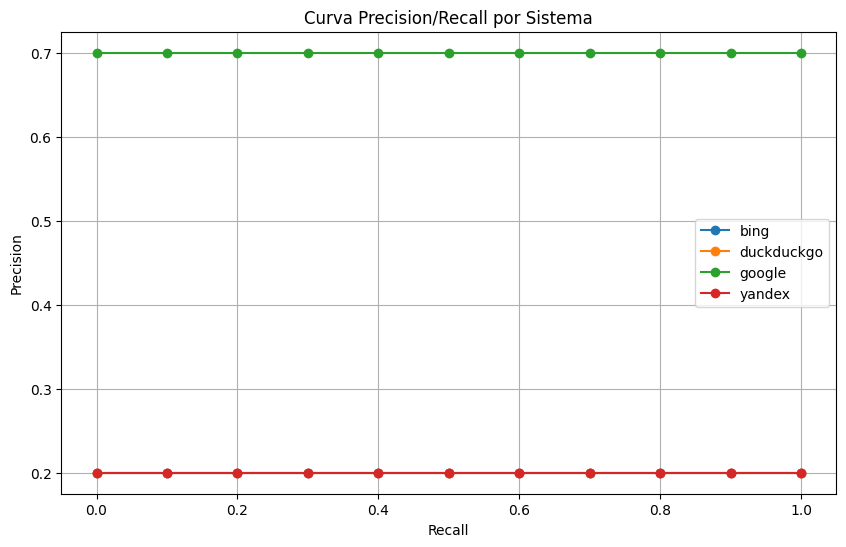

In [14]:
graficar_precision_recall_curve(ranking_rels, num_puntos=11)

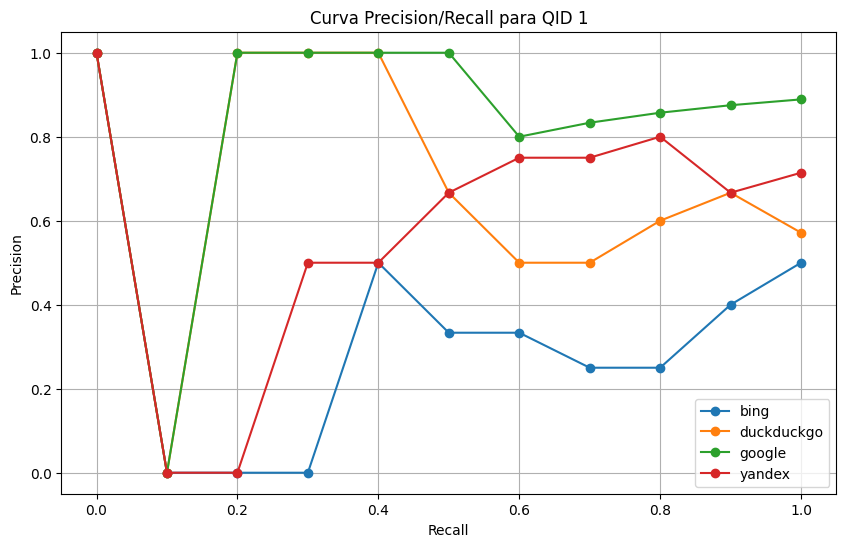

In [15]:
from sklearn.metrics import precision_recall_curve, auc
import pandas as pd

def calcular_precision_recall_curve(ranking, qid, systems):
    plt.figure(figsize=(10, 6))

    for system in systems:
        ranking_system = ranking[(ranking['qid'] == qid) & (ranking['system'] == system)]

        # Ordenar el ranking por score de manera descendente
        ranking_system = ranking_system.sort_values(by='score', ascending=False)

        # Calcular la curva de precisión y recuperación
        total_relevant = sum(ranking_system['rel'] != 0)
        recalls = np.linspace(0.0, 1.0, num=11)
        precision_interp = []

        for recall_target in recalls:
            if recall_target == 0.0:
              precision_k_r = 1
            else:
              k_r = int(recall_target * total_relevant)
              precision_k_r = sum(ranking_system['rel'].iloc[:k_r] != 0) / k_r if k_r > 0 else 0
            precision_interp.append(precision_k_r)

        # Tracer la curva de precisión y recuperación
        plt.plot(recalls, precision_interp, marker='o', linestyle='-', label=system)

    plt.title(f'Curva Precision/Recall para QID {qid}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejemplo de uso
qid_ejemplo = 1
systems_ejemplo = ranking_rels['system'].unique()
calcular_precision_recall_curve(ranking_rels, qid_ejemplo, systems_ejemplo)

##### nDCG

In [16]:
def calcular_ndcg(ranking, qid=None, system=None, top_k=10):
    # Filtrar el DataFrame según qid y system si se especifican
    if qid is not None:
        ranking = ranking[ranking['qid'] == qid]

    if system is not None:
        ranking = ranking[ranking['system'] == system]
    # Aplicar top_k si se especifica
    if top_k is not None:
        ranking = ranking.head(top_k)

    # Ordenar el DataFrame por posición (pos) en orden ascendente
    ranking = ranking.sort_values(by='pos')

    g = 0
    k = 0
    ideal_relevance = ranking['rel'].astype(float)
    ideal_relevance = np.sort(ideal_relevance)[::-1]
    dcg = []
    idcg = []
    for _, row in ranking.iterrows():
      #Grado de relevancia
      g = row['rel']
      k = row['pos']
      dcg.append((g)/np.log2(k+1))
      idcg.append((ideal_relevance[k-1])/np.log2(k+1))

    return sum(dcg)/sum(idcg)


##### Mean Reciprocal Rank (MRR)

In [17]:
def calcular_mrr(ranking, qid=None, system=None, top_k=None):
    """
    Calcula el Mean Reciprocal Rank (MRR) para un DataFrame de ranking.

    Parámetros:
    - ranking (pd.DataFrame): DataFrame con columnas 'qid', 'docid', 'rel', 'score', 'system'.
    - qid (str o None): QID para filtrar el ranking (opcional).
    - system (str o None): System para filtrar el ranking (opcional).
    - top_k (int o None): Número máximo de documentos considerados en el ranking (opcional).

    Retorna:
    - MRR (float): Mean Reciprocal Rank.
    """
    # Filtrar por qid y system si se especifican
    if qid is not None:
        ranking = ranking[ranking['qid'] == qid]
    if system is not None:
        ranking = ranking[ranking['system'] == system]

    # Ordenar el ranking por score de manera descendente
    ranking = ranking.sort_values(by='score', ascending=False)

    # Aplicar top_k si se especifica
    if top_k is not None:
        ranking = ranking.head(top_k)

    # Encontrar el rango del primer documento relevante
    first_relevant_rank = ranking[ranking['rel'] != 0]['pos'].min()

    # Calcular el MRR
    if pd.notna(first_relevant_rank):
        mrr = 1 / first_relevant_rank
        return mrr
    else:
        # No hay documentos relevantes en el ranking
        return 0.0

# Ejemplo de uso:
# Supongamos que ranking_rels es tu DataFrame con columnas 'qid', 'system', 'rel', 'score', 'pos'.
mrr_result = calcular_mrr(ranking_rels, qid='1', system='google', top_k=10)
print(f"MRR: {mrr_result:.4f}")


MRR: 0.0000


##### Rank-Biased Precision (RBP)

In [18]:
def calcular_rbp(ranking, qid=None, system=None, p=0.8, top_k=None):
    """
    Calcula el Rank Biased Precision (RBP) para un DataFrame de ranking.

    Parámetros:
    - ranking (pd.DataFrame): DataFrame con columnas 'qid', 'docid', 'pos', 'score', 'system', 'rel'.
    - qid (str o None): QID para filtrar el ranking (opcional).
    - system (str o None): System para filtrar el ranking (opcional).
    - p (float): Probabilidad de pasar al documento siguiente (0 < p <= 1).
    - top_k (int o None): Número máximo de documentos considerados en el ranking (opcional).

    Retorna:
    - RBP (float): Rank Biased Precision.
    """
    # Filtrar por qid y system si se especifican
    if qid is not None:
        ranking = ranking[ranking['qid'] == qid]
    if system is not None:
        ranking = ranking[ranking['system'] == system]

    # Ordenar el ranking por score de manera descendente
    ranking = ranking.sort_values(by='score', ascending=False)

    # Aplicar top_k si se especifica
    if top_k is not None:
        ranking = ranking.head(top_k)

    # Calcular RBP
    g = 0
    k = 0
    acum_p = 0
    for _, row in ranking.iterrows():
      #Grado de relevancia
      if row['rel'] == 0:
        g = 0
      else:
        g = 1
      k = row['pos']
      acum_p += (p**(k-1))*g

    return (1-p)*acum_p

##### Expected Reciprocal Rank (ERR)

In [19]:
def calcular_err(ranking, qid=None, system=None, top_k=None):
    """
    Calcula el Expected Reciprocal Rank (ERR) para un DataFrame de ranking.

    Parámetros:
    - ranking (pd.DataFrame): DataFrame con columnas 'qid', 'docid', 'pos', 'score', 'system', 'rel'.
    - qid (str o None): QID para filtrar el ranking (opcional).
    - system (str o None): System para filtrar el ranking (opcional).
    - top_k (int o None): Número máximo de documentos considerados en el ranking (opcional).

    Retorna:
    - ERR (float): Expected Reciprocal Rank.
    """
    # Filtrar por qid y system si se especifican
    if qid is not None:
        ranking = ranking[ranking['qid'] == qid]
    if system is not None:
        ranking = ranking[ranking['system'] == system]
    # Ordenar el ranking por score de manera descendente
    ranking = ranking.sort_values(by='score', ascending=False)

    # Aplicar top_k si se especifica
    if top_k is not None:
        ranking = ranking.head(top_k)

    # Calcular ERR
    err = 0
    k=0
    acum_mult = np.array([])
    p_r_d = np.array([])
    max_g = 1#max(ranking_rels['rel'])
    for _, row in ranking.iterrows():
      #Grado de relevancia
      if row['rel'] == 0:
        g = 0
      else:
        g = 1
      #g=row['rel']
      k = row['pos']
      # Calculo de p(r|d)
      p_r_d_value = ((2**g) - 1)/(2 ** max_g)

      # Lista con el calculo de los terminos:   1/k * p(r|d)
      p_r_d = np.append(p_r_d, (1/k) * (p_r_d_value))

      # Lista con el calculo de los terminos 1 - p(r|d)
      acum_mult = np.append(acum_mult,1-p_r_d_value)

    # Sumatorio para obtener ERR
    for i in range(len(p_r_d)):
      err += (p_r_d[i])*(acum_mult[:i].prod())

    return err

##### Ejemplos para pruebas

In [20]:
syst = 'duckduckgo'

# Ejemplo de uso:
# Supongamos que ranking_reals es tu DataFrame con columnas 'qid', 'system', 'rel'.
precision_qid_1 = calcular_precision(ranking_rels, qid=1)
precision_system_bing = calcular_precision(ranking_rels, system=syst, qid=1, top_k=10)
precision_top_5_qid_1 = calcular_precision(ranking_rels, qid=1, top_k=6)

print("Precisión para qid=1:", precision_qid_1)
print("Precisión para system='bing':", precision_system_bing)
print("Precisión top 5 para qid=1:", precision_top_5_qid_1)


# Ejemplo de uso:
# Supongamos que ranking_reals es tu DataFrame con columnas 'qid', 'system', 'rel'.
recall_qid_1 = calcular_recall(ranking_rels, qid=1)
recall_system_bing = calcular_recall(ranking_rels, system=syst, qid=1, top_k=10)
recall_top_5_qid_1 = calcular_recall(ranking_rels, qid=1, top_k=5)

print("Recall para qid=1:", recall_qid_1)
print("Recall para system='bing':", recall_system_bing)
print("Recall top 5 para qid=1:", recall_top_5_qid_1)

# Ejemplo de uso:
# Supongamos que ranking_reals es tu DataFrame con columnas 'qid', 'system', 'rel'.
f_score_qid_1 = calcular_f_score(ranking_rels, alpha=0.5, qid=1)
f_score_system_bing = calcular_f_score(ranking_rels, alpha=0.5,system=syst, qid=1, top_k=10)
f_score_top_5_qid_1 = calcular_f_score(ranking_rels, alpha=0.5, qid=1, top_k=5)

print("F-score para qid=1:", f_score_qid_1)
print("F-score para system='bing':", f_score_system_bing)
print("F-score top 5 para qid=1:", f_score_top_5_qid_1)

# Ejemplo de uso:
# Supongamos que ranking_rels es tu DataFrame con columnas 'qid', 'system', 'rel', 'score'.
#graficar_precision_recall_curve(ranking_rels, num_puntos=11)

# Ejemplo de uso:
# Supongamos que ranking_rels es tu DataFrame con columnas 'qid', 'docid', 'pos', 'score', 'system', 'rel'.
rbp_result = calcular_rbp(ranking_rels, system= 'bing', qid=5,p=0.8)
print(f"RBP: {rbp_result:.4f}")


# Ejemplo de uso:
# Supongamos que ranking_rels es tu DataFrame con columnas 'qid', 'docid', 'pos', 'score', 'system', 'rel'.
err_result = calcular_err(ranking_rels, qid=3, system='bing', top_k=10)
print(f"ERR: {err_result:.4f}")

Precisión para qid=1: 0.725
Precisión para system='bing': 0.7
Precisión top 5 para qid=1: 0.5
Recall para qid=1: 1.0
Recall para system='bing': 1.0
Recall top 5 para qid=1: 1.0
F-score para qid=1: 0.8405797101449275
F-score para system='bing': 0.8235294117647058
F-score top 5 para qid=1: 0.5714285714285714
RBP: 0.7116
ERR: 0.6250


In [21]:
ranking_rels[(ranking_rels['system']=='bing')&(ranking_rels['qid']==5)]

,qid,docid,pos,score,system,rel
200,5,https://www.popsci.com/science/gallery/2013-06...,1,10,bing,1
201,5,https://www.quotes.net/show-quote/62027,2,9,bing,2
202,5,https://www.bing.com/videos/search?q=what+kind...,3,8,bing,2
203,5,https://www.greenbelly.co/pages/types-of-bears,4,7,bing,1
204,5,https://bearwithus.org/8-bears-of-the-world/,5,6,bing,0
205,5,https://a-z-animals.com/animals/bear/,6,5,bing,0
206,5,https://www.activewild.com/types-of-bears/,7,4,bing,1
207,5,https://wildlifeinformer.com/types-of-bears/,8,3,bing,1
208,5,https://www.britannica.com/animal/bear,9,2,bing,0
209,5,https://www.imdb.com/title/tt1008441/character...,10,1,bing,2


##### Calculo de métricas y promedios

In [22]:
# Calculo por query
metricas_totales=[]
for s in ranking_rels['system'].unique():
  for q in ranking_rels['qid'].unique():
    p =calcular_precision(ranking_rels,qid=q,system=s)
    r=calcular_recall(ranking_rels,qid=q,system=s)
    f=calcular_f_score(ranking_rels,qid=q,system=s)
    ndcg = calcular_ndcg(ranking_rels,qid=q,system=s)
    mrr = calcular_mrr(ranking_rels,qid=q,system=s)
    err = calcular_err(ranking_rels,qid=q,system=s)
    rbp = calcular_rbp(ranking_rels,qid=q,system=s, p=0.8)

    metricas_totales.append([s,q,p,r,f,ndcg,mrr,err,rbp])
metricas_totales_df = pd.DataFrame(metricas_totales,
                                   columns=["Buscador", "Query", "P@10", "R@10", "F@10", "nDCG","MRR", "ERR", "RBP"])

# Calculo de promedio por browser
promedios_df = metricas_totales_df.groupby("Buscador").agg({
    "P@10": "mean",
    "R@10": "mean",
    "F@10": "mean",
    "nDCG": "mean",
    "MRR": "mean",
    "ERR": "mean",
    "RBP": "mean"
}).reset_index()
promedios_df['Query']="Promedio"

# Unir el DataFrame original con los promedios
metricas_totales_df = pd.concat([metricas_totales_df, promedios_df], ignore_index=True)

metricas_totales_df.sort_values(by=["Buscador","Query"])

,Buscador,Query,P@10,R@10,F@10,nDCG,MRR,ERR,RBP
0,bing,0,0.200000,1.0,0.333333,0.693426,0.500000,0.333333,0.288000
1,bing,1,0.600000,1.0,0.750000,0.695204,0.500000,0.334797,0.420283
2,bing,2,0.200000,1.0,0.333333,0.608933,1.000000,0.527778,0.233554
3,bing,3,0.200000,1.0,0.333333,1.000000,1.000000,0.625000,0.360000
4,bing,4,0.200000,1.0,0.333333,0.571429,0.500000,0.277778,0.193554
5,bing,5,0.700000,1.0,0.823529,0.852752,1.000000,0.689490,0.711615
6,bing,7,0.800000,1.0,0.888889,0.947572,1.000000,0.692513,0.806643
7,bing,8,0.300000,1.0,0.461538,0.941061,1.000000,0.640625,0.401943
8,bing,9,0.900000,1.0,0.947368,0.982455,1.000000,0.692945,0.859071
36,bing,Promedio,0.455556,1.0,0.578295,0.810315,0.833333,0.534918,0.474963


####Test de significacia estadistica


Reportar la significatividad estadística de la comparación entre los dos mejores sistemas.

In [23]:
# Parámetros
buscador_1 = 'bing'
buscador_2 = 'google'
alpha = 0.05  # Nivel de significancia
# Seleccionar la métrica
metricas = [ "P@10", "R@10", "F@10", "nDCG","MRR", "ERR", "RBP"]

# Filtrar las líneas donde Query no es 'Promedio'
filtered_df = metricas_totales_df[metricas_totales_df['Query'] != 'Promedio']

# Seleccionar los dos sistemas que deseas comparar
sistema_1 = filtered_df[filtered_df['Buscador'] == buscador_1]
sistema_2 = filtered_df[filtered_df['Buscador'] == buscador_2]

print('Sistemas a comparar son: ', buscador_1, ' y ', buscador_2)

for m in metricas:
  print(m)
  # Realizar la prueba t de Student
  t_statistic, p_value = stats.ttest_ind(sistema_1[m], sistema_2[m])

  # Resultado T-Statistic y P-Value
  print(f'\tT-Statistic: {t_statistic}')
  print(f'\tP-Value: {p_value}')

  # Interpretación de resultado

  print('\n\tCon un nivel de confianza de ',(1-alpha)*100,'%')
  if p_value < alpha:
      print('\tLa diferencia es estadísticamente significativa.\n')
  else:
      print('\tNo hay evidencia suficiente para afirmar que hay una diferencia estadísticamente significativa.\n')

Sistemas a comparar son:  bing  y  google
P@10
	T-Statistic: -1.557848117212496
	P-Value: 0.13882715931023987

	Con un nivel de confianza de  95.0 %
	No hay evidencia suficiente para afirmar que hay una diferencia estadísticamente significativa.

R@10
	T-Statistic: nan
	P-Value: nan

	Con un nivel de confianza de  95.0 %
	No hay evidencia suficiente para afirmar que hay una diferencia estadísticamente significativa.

F@10
	T-Statistic: -1.4850495196706441
	P-Value: 0.1569658662704261

	Con un nivel de confianza de  95.0 %
	No hay evidencia suficiente para afirmar que hay una diferencia estadísticamente significativa.

nDCG
	T-Statistic: -0.6016952214825377
	P-Value: 0.5558076255183502

	Con un nivel de confianza de  95.0 %
	No hay evidencia suficiente para afirmar que hay una diferencia estadísticamente significativa.

MRR
	T-Statistic: -0.5946353169977339
	P-Value: 0.5604029349232258

	Con un nivel de confianza de  95.0 %
	No hay evidencia suficiente para afirmar que hay una diferenci

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


#### Pyterrier - `ir_measures`

##### Instalación e importación de `ir_measures`

In [24]:
#Instalación de ir_measures
!pip install -q git+https://github.com/terrierteam/ir_measures

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [25]:
# Importanción de ir_measures
import ir_measures
from ir_measures import * # import natural measure names

##### Preperación de los set de datos

In [26]:
# Preparación de dataset para Pyterrier

custom_qrels = ranking_rels.copy()
custom_qrels = custom_qrels.rename(columns={'qid': 'query_id', 'docid': 'doc_id','rel': 'relevance'})
custom_qrels["query_id"] = custom_qrels["query_id"].astype(str)
custom_qrels["doc_id"] = custom_qrels["doc_id"].astype(str)
custom_qrels["relevance"] = custom_qrels["relevance"].astype(int)

In [27]:
custom_qrels['score'].dtype

dtype('int64')

##### Ejecución de los cálculos

In [28]:
# Calculo por query
metricas_ir=[]
for s in ranking_rels['system'].unique():
  # Filtrado y copia de los rankings para un sistema especifico
  ranking_s = ranking_rels[ranking_rels['system']==s].copy()

  # Construcción del qrels para el sistema s
  qrels_s = ranking_s
  qrels_s = qrels_s.rename(columns={'qid': 'query_id', 'docid': 'doc_id','rel': 'relevance'})
  qrels_s["query_id"] = qrels_s["query_id"].astype(str)
  qrels_s["doc_id"] = qrels_s["doc_id"].astype(str)
  qrels_s["relevance"] = qrels_s["relevance"].astype(int)

  # Construcción del run para el sistema s
  run_s = ranking_s
  run_s = run_s.rename(columns={'qid': 'query_id', 'docid': 'doc_id','score': 'score'})
  run_s["query_id"] = run_s["query_id"].astype(str)
  run_s["doc_id"] = run_s["doc_id"].astype(str)
  run_s["score"] = run_s["score"].astype(int)

  for metric in ir_measures.iter_calc([P(rel=1)@10,R(rel=1)@10,SetF, nDCG(dcg='log2')@10,RR,ERR@10, RBP(rel=1, p=0.8)], qrels_s, run_s):
    metric_s = list(metric[0:3])
    metric_s.insert(0,s)
    metricas_ir.append(metric_s)

# Convertimos la lista de listas en un DataFrame
metricas_ir_df = pd.DataFrame(metricas_ir, columns=['Sistema', 'Query', 'Id', 'Valor'])

# Pivoteamos el DataFrame para que las métricas se conviertan en columnas
metricas_ir_df = metricas_ir_df.pivot(index=['Sistema', 'Query'], columns='Id', values='Valor')

# Restablecemos el índice para que 'Sistema' y 'Query' vuelvan a ser columnas

# Reordenamos las columnas según el orden deseado
orden = [1,2,4,3,0,6,5]
# Reordenamos las columnas para que se vean igual df anterior
metricas_ir_df = metricas_ir_df.iloc[:,orden]
metricas_ir_df = metricas_ir_df.reset_index()
metricas_ir_df[metricas_ir_df['Sistema']=='google']

Id,Sistema,Query,P@10,R@10,SetF,nDCG@10,RR,ERR@10,RBP(rel=1)
18,google,0,0.1,1.0,0.181818,0.356207,0.166667,0.01042,0.065536
19,google,1,0.9,1.0,0.947368,0.848366,1.000000,0.15929,0.810706
20,google,2,0.5,1.0,0.666667,0.974476,1.000000,0.31513,0.603474
21,google,3,0.7,1.0,0.823529,0.975277,1.000000,0.35377,0.741919
22,google,4,0.4,1.0,0.571429,0.844955,1.000000,0.25814,0.436764
23,google,5,0.8,1.0,0.888889,0.964715,1.000000,0.30753,0.823839
24,google,7,1.0,1.0,1.000000,0.946438,1.000000,0.32309,0.892626
25,google,8,0.8,1.0,0.888889,0.917317,1.000000,0.30599,0.806643
26,google,9,0.8,1.0,0.888889,0.932013,1.000000,0.28967,0.823839


In [29]:
metricas_totales_df[metricas_totales_df['Buscador']=='google']

,Buscador,Query,P@10,R@10,F@10,nDCG,MRR,ERR,RBP
18,google,0,0.100000,1.0,0.181818,0.356207,0.166667,0.083333,0.065536
19,google,1,0.900000,1.0,0.947368,0.848366,1.000000,0.691338,0.810706
20,google,2,0.500000,1.0,0.666667,0.974476,1.000000,0.682639,0.603474
21,google,3,0.700000,1.0,0.823529,0.975277,1.000000,0.690600,0.741919
22,google,4,0.400000,1.0,0.571429,0.844955,1.000000,0.614583,0.436764
23,google,5,0.800000,1.0,0.888889,0.964715,1.000000,0.692696,0.823839
24,google,7,1.000000,1.0,1.000000,0.946438,1.000000,0.693065,0.892626
25,google,8,0.800000,1.0,0.888889,0.917317,1.000000,0.692513,0.806643
26,google,9,0.800000,1.0,0.888889,0.932013,1.000000,0.692696,0.823839
38,google,Promedio,0.666667,1.0,0.761942,0.862196,0.907407,0.614829,0.667261


# 2.  Evaluación con métricas de negocio

### Lectura de los logs simulados

In [ ]:
# !pip install -U -q PyDrive2
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Leemos el log de interacción simulada preparado por el profesor a los dataframes de queries y engagement.
drive.CreateFile({'id':'1KwuB8yLDNDYdnW1h-51vImle1iHzv0Bt'}).GetContentFile('query-requests.csv')
# Backup: la siguiente línea, comentada, lee la versión inicialmente proporcionada del log
# drive.CreateFile({'id':'1r1ZRLI9uiAoFjiZXj1dHhRi2VsPXKQ6t'}).GetContentFile('impressions.csv')
query_requests = pd.read_csv('query-requests.csv')

drive.CreateFile({'id':'1ox0FGfOKNCMPSpGcLcPhUE_oBuuTC2uE'}).GetContentFile('engagement-log.csv')
# Backup: la siguiente línea, comentada, lee la versión inicialmente proporcionada del log
# drive.CreateFile({'id':'1RuI7EKyFzhm6cBOoKkfY740PlcSrRqDx'}).GetContentFile('engagement-log.csv')
engagement = pd.read_csv('engagement-log.csv')

### Cálculo de las métricas de negocio

In [ ]:
# Código aquí (usando los datos en 'impressions' y 'engagement').

# 3.  Opcional: evaluación online intercalada

In [ ]:
# Código aquí.

# 4.  Opcional: evaluación de los rankers implementados en la práctica 1

Procesar [el conjunto de URLs](https://docs.google.com/spreadsheets/d/1nWr6r1ZkLH29WTyhqr4oz05HgvQv0tmE-IPHdZUex0c/edit#gid=1095978917) de esta práctica 2 utilizando el código de la práctica 1, de forma que se aplique la misma extracción de términos.

Partiendo de ahí, ejecutar los modelos implementados en la práctica 1 (VSM, BM25, QLD), así como los de PyTerrier, sobre las consultas y documentos de la práctica 2, y evaluarlos con los juicios de relevancia de esta práctica y las métricas implementadas en el ejercicio 1.

De esta forma el estudiante podrá comparar qué implementaciones de rankers de la práctica 1 eran más efectivas en esta nueva colección de documentos y consultas.

In [ ]:
# Indicación: el conjunto de URLs de esta práctica es qrels.docid.unique().

# Código aquí.

In [ ]:
#!pip install PyTerrier

In [32]:
import numpy as np
import math
from tabulate import tabulate
#np.seterr(divide='ignore', invalid='ignore')

####VMS

In [91]:
class VSM:
  def __init__(self, freqvector, docfreqs):
    self.freqvector = freqvector
    self.docfreqs = docfreqs

  def search(self, q):
    # Calculamos los cosenos de todos los documentos.
    ranking = [(url, self.dotproduct(url, q) / self.module(url)) for url in self.freqvector]
    # Eliminamos los documentos con coseno = 0.
    ranking = [(url, cos) for url, cos in ranking if cos > 0]
    # Ordenamos.
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking

  def dotproduct(self, url, q):
    _dotproduct = 0
    for word in q:
      _dotproduct += self.idf(word)*self.tf(word, url)
    return _dotproduct

  def module(self, url):
    mod = 0 # Módulo de la url
    for word in self.freqvector[url].keys():
      mod += (self.idf(word) * self.tf(word, url)) ** 2 # Aumento del módulo
    return math.sqrt(mod) # Devolvemos la raiz cuadrada

  def tf(self, word, url): #Se aplica suavizado
    try:
        if self.freqvector is not None and url in self.freqvector:
            word_freq = self.freqvector[url].get(word)
            if word_freq is not None:
              if word_freq > 0:
                return 1 + math.log2(word_freq)
              else:
                return 0
    except TypeError:
        pass
    return 0

  def idf(self,word): #Se aplica suavizado
    num = len(self.freqvector)+1

    if self.docfreqs.get(word) == None:
      den = 0.5
    else:
      den = self.docfreqs.get(word) + 0.5
    return math.log2(num/den)

####BM25

In [89]:
from types import NoneType
# Nota: cuando una palabra aparece en más de la mitad de la colección, resulta un score BM25 negativo.
# Una forma de evitarlo es tomar un número mínimo de documentos como |D|, es decir usar por ejemplo
# |D| = max(20, len(freqvector))
class BM25:
  def __init__(self, freqvector, docfreqs, b, k):
    self.freqvector = freqvector
    self.docfreqs = docfreqs
    self.b = b
    self.k = k
    self.average_d = self.calc_average_d()

  def search(self, q):
    ranking = []

    for url in self.freqvector:
      rank = 0
      for word in q:
        rank += (self.numerator(url,word)/self.denominator(url,word)) * self.rsj(word)
      ranking.append([url,rank])

    # Eliminamos los documentos con coseno = 0.
    ranking = [(url, cos) for url, cos in ranking if cos > 0]

    # Ordenamos.
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking

  def numerator(self, url, q):
    num = 0
    if self.freqvector is not None and url in self.freqvector:
      word_freq = self.freqvector[url].get(q)
      if word_freq is not None:
        num = (self.k + 1) * word_freq
      else:
        num = 0
    return num

  def denominator(self, url, q):
    den = 0
    if self.freqvector is not None and url in self.freqvector:
      word_freq = self.freqvector[url].get(q)
      if word_freq is not None:
        den += self.k * (1 - self.b + (self.b * sum(self.freqvector[url].values())/self.average_d)) + word_freq
      else:
        den += self.k * (1 - self.b + (self.b * (sum(self.freqvector[url].values())/self.average_d))) + 0
    return den

  def rsj(self, word): # Se aplica suavizado
    if self.docfreqs.get(word) is not None:
      numerator = max(20,len(self.freqvector)) - self.docfreqs.get(word)+0.5# + self.b
      denominator = self.docfreqs.get(word)+0.5# + self.b
    else:
      numerator = max(20,len(self.freqvector)) +0.5# + self.b
      denominator = 0.5# + self.b
    return math.log2(numerator/denominator)

  def calc_average_d(self):
    average_d = []
    for url in self.freqvector:
      average_d.append(sum(self.freqvector[url].values()))
    self.average_d = np.average(average_d)
    return self.average_d

####QLD

In [102]:
class QLD:
  def __init__(self, freqvector, wordfreqs, mu):
    self.freqvector = freqvector
    self.wordfreqs = wordfreqs
    self.mu = mu
    #self.D

  def search(self, q):
    ranking = []

    for url in self.freqvector.keys():
      rank = 1.0

      # Obtenemos el tamaño del documento
      len_doc = sum(self.freqvector[url].values())
      #for w in q:
      # Calculamos el valor p-gorro de la palabra
      p_w = self.p_c(q)

      # Obtenemos la frecuencia de la palabra en el documento
      frec_w_d = self.freqvector[url].get(q, 0)

      # Calculamos su rango con suavizado Dirichlet
      rank *= (frec_w_d + self.mu * p_w)/(len_doc + self.mu)
    ranking.append([url, rank])

    # Eliminamos los documentos con valor menor que cero
    #ranking = [(url, cos) for url, cos in ranking if cos > 0]

    # Ordenamos por orden de rango
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking

  def p_c(self, w):
    '''
      Función que devuelve la probabilidad de la palabra 'w'.
      Necesaria para el suavizado de Dirichlet
    '''
    sum_freq = np.array([self.freqvector[url].get(w, 0) for url in self.freqvector.keys()]).sum()
    len_total = 0
    for url in self.freqvector.keys():
      for w in self.freqvector[url].keys():
        len_total += self.freqvector[url][w]

    return sum_freq / len_total

### Set de pruebas

##### 1. Colección

In [70]:
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
from collections import Counter
import re
from urllib.error import HTTPError
from tqdm import tqdm
import time
import string

# La colección: una pequeña lista de URLs web.
urls = list(qrels[qrels['qid']==3]['docid'])
#urls=urls[4:9]
texts = []

# Crear una barra de progreso
progress_bar = tqdm(total=len(urls), desc="Processing URLs", unit="URL")

for url in urls:
    try:
        # Simula el proceso con un sleep de 1 segundo
        time.sleep(1)

        # Leer la página y procesar el texto
        #text = BeautifulSoup(urlopen(url).read(), "lxml").text.lower()

        text = BeautifulSoup(requests.get(url).text, "lxml").text.lower()
        #if text.isascii():
        #text = [word for word in text if word.isascii()]
        texts.append(text)

    # Indica las url que no se pueden procesar
    except HTTPError as e:
        print(f"Error accessing {url}: {e}")
        continue
    finally:
        # Actualizar la barra de progreso después de procesar cada URL
        progress_bar.update(1)

# Cerrar la barra de progreso
progress_bar.close()

# Leemos los documentos y quitamos las marcas HTML.
#texts = [BeautifulSoup(urlopen(url).read(), "lxml").text.lower() for url in urls]

# Una lista ad-hoc de stopwords.
stoplist = ["also", "could", "p", "pp", "th", "however", "one", "two", "many", "i", "de", "la", "me", "my", "myself", "the", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

Processing URLs: 100%|██████████| 29/29 [04:04<00:00,  8.45s/URL]


##### 2.  Extracción y construcción de bag of words

In [84]:
# Nos abstraemos de los detalles reales de indexación, y utilizaremos un manejo muy simplificado del texto.

# Vector de frecuencias para todos los documentos de la colección, usando la subclase de diccionario collections.Counter.
# Para cada documento, separamos el texto en lista de palabras, y Counter genera un diccionario palabra:frecuencia.
# Se construye un diccionario url -> word -> count (se denomina un "índice forward").
#freqvector = {url:Counter([word for word in re.findall(r"[^\W\d_]+|\d+", text) if word not in stoplist]) for url, text in zip(urls, texts)}
freqvector = {url:Counter([word for word in re.findall(r"[^\W\d_]+|\d+", text) if word not in stoplist  and word.isascii()]) for url, text in zip(urls, texts)}

#Quitando los vacios por consultas no accesadas
freqvector = {url: counter for url, counter in freqvector.items() if counter}

# Guardamos el vocabulario (el conjunto de todas las palabras que apaercen en los documentos de la colección).
vocabulary = set()
for word in freqvector.values(): vocabulary.update(word)

# Document frequency de cada palabra del vocabulario: nº de documentos que contienen la palabra.
docfreqs = {word:len([url for url in freqvector if word in freqvector[url]]) for word in vocabulary}

# Frecuencia total para cada palabra del vocabulario: nº total de apariciones en la colección.
wordfreqs = {word:sum([freqvector[url][word] for url in freqvector if word in freqvector[url]]) for word in vocabulary}

##### 3.  Consultas de prueba

In [104]:
# Probamos la consulta
query = 'autopsy training students'

for q in query.split(' '):
    print('\n+-------------------------------------------------------------+')
    print("\033[1m" + f'Query: {q}'+ "\033[0m")

    # Modelos
    vsm_results = VSM(freqvector, docfreqs).search(q)
    bm25_results = BM25(freqvector, docfreqs, b=0.5, k=1).search(q)
    qld_results = QLD(freqvector, wordfreqs, mu=3000).search(q)

    # Imprimir resultados utilizando tabulate
    print("\033[1m" + '\nModelo vectorial'+ "\033[0m")
    vsm_formatted = [(score, url) for url, score in vsm_results]
    print(tabulate(vsm_formatted, headers=["Score", "URL"]))

    print("\033[1m" + '\nBM25'+ "\033[0m")
    bm25_formatted = [(score, url) for url, score in bm25_results]
    print(tabulate(bm25_formatted, headers=["Score", "URL"]))

    print("\033[1m" + '\nQuery likelihood + Dirichlet'+ "\033[0m")
    qld_formatted = [(score, url) for url, score in qld_results]
    print(tabulate(qld_formatted, headers=["Score", "URL"]))


+-------------------------------------------------------------+
Query: autopsy

Modelo vectorial
    Score  URL
---------  ---------------------------------------------------------------------------------------------------
0.317576   https://www.slu.edu/medicine/clinics-community/aims/pdfs/forensic-autopsy-cadaver-demonstration.pdf
0.0729515  https://cci.calpoly.edu/sites/default/files/2021-06/2020_autopsy_training_manual_FULL.pdf
0.046099   https://link.springer.com/chapter/10.1007/978-3-319-98373-8_6
0.0314931  https://www.sju.edu/news/death-education-preparing-teens-end-life-issues
0.0292775  https://www.gcu.edu/blog/medical-studies-sciences/how-become-autopsy-technician
0.0219251  https://vimeo.com/411728312
0.0206822  https://link.springer.com/article/10.1007/s00414-014-0974-4

BM25
   Score  URL
--------  ---------------------------------------------------------------------------------------------------
13.9653   https://cci.calpoly.edu/sites/default/files/2021-06/2020_autopsy_t